# **Digital Signal and Image Management - 1D Signal Processing**<br/>

---

#Human Activity Recognition using Smartphone Accelerometer Data

Authors:

Luca Galli - 905236 | Davide Ronchi - 903320

---



# Contents

This notebook aims to explore and implement various machine learning techniques for **Human Activity Recognition** using smartphone sensor data. The dataset used is the [**WISDM dataset**](https://www.cis.fordham.edu/wisdm/dataset.php), that contains accelerometer readings from smartphones worn by individuals performing different activities like walking, jogging, sitting, etc.

The notebook covers the following aspects:
* Load the cleaned dataframe from the **"1 - Preprocessing"** notebook using an *ad hoc* `data_loader` function to preprocess it;
* Extract time and frequency **domain features** like energy, zero-crossing rate, FFT coefficients, mel spectrogram, and MFCCs.
* Train different **Support Vector Machine (SVM)** models to classify these activities with each feature extractor;
* Train some **Neural Network** models; we will use raw signal, without performing feature extraction on some LSTM architectures
* Perform **Data Augmentation** on training data:
  - We will try to obtain **rotation invariance** of the signal, such that the model will be more robust even in case the smartphone recording the signal is placed rotated inside the pocket;
  - Apply **jittering** to the signals balancing classes
* Train the same LSTM model (LSTM3) on the augmented data

# Importing Libraries

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import os
from io import StringIO
import re
import seaborn as sns
from tqdm import tqdm
import pickle
import random

import sklearn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder


# Model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout, Activation, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.utils import plot_model

from scipy.io import arff
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from scipy.spatial.transform import Rotation
from librosa.feature import melspectrogram, mfcc

from time import time

import joblib

from itertools import product
import itertools

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setting seed for reproducibility

In [3]:
seed = 123456

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Data Loading

Define base path

In [5]:
base_path = '/content/drive/MyDrive/DSaIM_project/1D/'

Loading the cleaned dataframe

In [10]:
data = pd.read_pickle(base_path + 'Digital-Signal-and-Image-Processing/cleaned_dataframe.pkl')

In [11]:
data.head()

,time,ax,ay,az,user,activity,rec_n
0,0.00,0.690000,10.800000,-2.030000,1,walking,1
1,0.05,6.849144,7.439339,-0.499961,1,walking,1
2,0.10,0.930550,5.630084,-0.500053,1,walking,1
3,0.15,-2.110598,5.009791,-0.690298,1,walking,1
4,0.20,-4.592067,4.289055,-1.951342,1,walking,1


Data Loader Function Definition

In [12]:
sampling_rate = 20 # [Hz]
signal_length = 5 # [seconds]
activities = ['walking', 'jogging', 'sitting', 'standing', 'upstairs', 'downstairs']
users = data['user'].unique()

def identity(input):
    return input

def load_data(data, overlap=0., dummy=False, feature_extractor=identity, standardize=False, reshape=False):

    # Group data per 'user', 'activity' and 'rec_n'--> each row in the output will contain a list (the signal)
    listed_signals = data.groupby(['user', 'activity','rec_n']).agg({
    'ax': lambda x: x.tolist(),
    'ay': lambda x: x.tolist(),
    'az': lambda x: x.tolist(),
    'activity': 'first'
    })

    tot_rec = len(listed_signals) # Total number of recorded signals in the dataframe
    features = []  # List of features
    labels = []  # List of labels

    # Loop through all the signals
    for s in range(tot_rec):
        curr_length = len(listed_signals.iloc[s]['ax'])    # Length of the current signal
        cursor = 0     # Cursor to move in the signal

        while cursor < curr_length:
            if curr_length - cursor >= signal_length * sampling_rate:  # If the current signal is longer than the signal length

                # Extract the 5 seconds signal starting from *cursor* and taking the next 5 seconds
                axs = np.array(listed_signals.iloc[s]['ax'][cursor : cursor + signal_length*sampling_rate])
                ays = np.array(listed_signals.iloc[s]['ay'][cursor : cursor + signal_length*sampling_rate])
                azs = np.array(listed_signals.iloc[s]['az'][cursor : cursor + signal_length*sampling_rate])

                # Apply feature_extractor to each of them
                features_x = feature_extractor(axs)
                features_y = feature_extractor(ays)
                features_z = feature_extractor(azs)

                # Append extracted features and label to the dedicated lists
                features.append([features_x, features_y, features_z])
                labels.append(listed_signals.index[s][1])

            elif (curr_length - cursor < signal_length * sampling_rate) & (curr_length > signal_length*sampling_rate):  # If the current signal is shorter than the signal length

                # Extract the 5 seconds signal starting from the end and going back 5 seconds
                axs = np.array(listed_signals.iloc[s]['ax'][-signal_length*sampling_rate:])
                ays = np.array(listed_signals.iloc[s]['ay'][-signal_length*sampling_rate:])
                azs = np.array(listed_signals.iloc[s]['az'][-signal_length*sampling_rate:])

                # Apply feature_extractor to each of them
                features_x = feature_extractor(axs)
                features_y = feature_extractor(ays)
                features_z = feature_extractor(azs)

                # Append extracted features and label to the dedicated lists
                features.append([features_x, features_y, features_z])
                labels.append(listed_signals.index[s][1])

            cursor += math.floor((signal_length*sampling_rate)*(1-overlap))

    # Convert labels into one-hot encoding
    if dummy:
        labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
    else:
        labels = np.asarray(labels)

    features = np.asarray(features)


    # Split the dataset in Training, Validation and Test set
    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=123, stratify=labels)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=123, stratify=y_train)

    # Standardize the features
    if standardize:
        X_train = np.array(X_train)

        x_axes = []
        y_axes = []
        z_axes = []

        for signal in X_train:
            x_axis = signal[0]
            x_axes.extend(x_axis)

            y_axis = signal[1]
            y_axes.extend(y_axis)

            z_axis = signal[2]
            z_axes.extend(z_axis)

        axes = np.array([x_axes, y_axes, z_axes], dtype=float).T

        # Create a scaler instance and standardize the features
        scaler_instance = StandardScaler()
        scaler = scaler_instance.fit(axes)

        print(f"Axes means: {scaler.mean_}" )
        print(f"Axes standard deviations: {scaler.scale_}")

        X_train = np.array([scaler.transform(signal.T).T for signal in X_train])
        X_val = np.array([scaler.transform(signal.T).T for signal in X_val])
        X_test = np.array([scaler.transform(signal.T).T for signal in X_test])

    # Reshape the data
    if reshape:
        X_train = X_train.reshape((X_train.shape[0], -1))
        X_val = X_val.reshape((X_val.shape[0], -1))
        X_test = X_test.reshape((X_test.shape[0], -1))

    return np.array(X_train), np.array(X_val), np.array(X_test), np.array(y_train), np.array(y_val), np.array(y_test), scaler.mean_, scaler.scale_

# Feature Extractors

We define some feature extractors to preprocess signals before feeding them into the Support Vector Machines

## Time domain features

### Energy

Measure the Energy of the signal
$$ E = \sum_i{x_i^2} $$

In [13]:
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

### ZCR (Zero-Crossing Rate)

The **Zero-Crossing Rate** Function has been implemented as follows:


$$\text{ZCR} = \frac{1}{2N}\sum_i{\vert \text{sgn}[x_{i+1}] - \text{sgn}[x_i] \vert}$$


Where
* $x_i$ is the $i^\text{th}$ sample of the signal and $x_{i+1}$ is the $(i+1)^\text{th}$
* $\text{sgn}[\cdot]$ is the *sign* function, i.e.: $$ \text{sgn}[\cdot] = \begin{cases}
      1 & x_i\geq 0 \\
      -1 & x_i\lt 0
   \end{cases}$$


* $\text{N}$ is the length of the signal


It returns the number of times the signal changes value, from positive to negative and vice versa, divided by the length of the frame.

Measures how many times the waveform crosses the zero axis.

In [14]:
def zcr(input):
  sum = 0
  for i in range(len(input)-1):
    par_sum = np.absolute(np.sign(input[i+1]) - np.sign(input[i]))
    sum += par_sum
  return np.array([sum / (2*len(input))])

### COMBO (Energy-ZCR)

We combine Energy and ZCR

In [15]:
def combo(input):
    return np.concatenate((energy(input),zcr(input)))

## Frequency domain features

### FFT (Fast Fourier Transform)

In [16]:
def feats_fourier(input):
    return np.real(rfft(input))

### Spectrogram


A spectrogram is a visual representation of the frequency spectrum of a 1D signal as it varies over time. It is created by dividing the signal into short segments, applying the Fourier transform to each segment to compute its frequency content, and displaying the resulting spectra as a heatmap, where the x-axis represents time, the y-axis represents frequency, and the color intensity represents the magnitude of the frequencies.

In [17]:
def feats_spectrogram(input, rate=20, tsize=10):
  [spec_freqs, spec_times, spec] = spectrogram(input, fs=rate, nperseg=64, nfft=64)
  output = spec.flatten()
  return output

### Mel Spectrogram

**Mel spectrogram** is a spectrogram where the frequencies are converted to the **Mel scale**.
Humans do not perceive frequencies on a linear scale. We are better at detecting differences in lower frequencies than higher frequencies. The *Mel scale* is such that equal distances in pitch sounded equally distant to the listener.

In [18]:
def feats_mel(input, rate=sampling_rate):
  mel = melspectrogram(y=input*1.0, sr=rate, n_fft=64, hop_length=32, n_mels=10)
  output = mel.flatten()
  return output

### MFCC (Mel Frequency Cepstrum Coefficients)

https://medium.com/@derutycsl/intuitive-understanding-of-mfccs-836d36a1f779

In [19]:
def feats_mfcc(input, rate=sampling_rate, flatten=True):
    mfccs = mfcc(y=input*1.0, sr=rate, n_fft=64, hop_length=32, n_mfcc=13, n_mels=10)
    if flatten:
        output = mfccs.flatten()
    else:
        output = mfccs
    return output

# Models Training

## SVM

### SVM - Energy

In [20]:
# Choose the feature extractor and modify the below 'load_data' function according to it
X_train, X_val, X_test, y_train, y_val, y_test, X_train_mean, X_train_std = load_data(data, overlap=0.5, feature_extractor=energy, standardize=True, reshape=True)

Axes means: [ 4873.58538804 10124.15491905  2382.40059265]
Axes standard deviations: [5562.25675148 6198.32269693 2717.95400904]


Save mean and standard deviation

In [ ]:
os.makedirs(base_path + 'training_data/SVM_energy/', exist_ok=True)

with open(base_path + 'training_data/SVM_energy/X_train_mean.pkl', 'wb') as f:
    pickle.dump(X_train_mean, f)

with open(base_path + 'training_data/SVM_energy/X_train_std.pkl', 'wb') as f:
    pickle.dump(X_train_std, f)

In [ ]:
print(f"X_train shape: \t{X_train.shape},\tmin value: {X_train.min():.3f}, \tmax value: {X_train.max():.3f}")
print(f"y_train shape: \t{y_train.shape}")

print(f"X_val shape: \t{X_val.shape},\tmin value: {X_val.min():.3f}, \tmax value: {X_val.max():.3f}")
print(f"y_val shape: \t{y_val.shape}")

print(f"X_test shape: \t{X_test.shape},\tmin value: {X_test.min():.3f}, \tmax value: {X_test.max():.3f}")
print(f"y_test shape: \t{y_test.shape}")

X_train shape: 	(16019, 3),	min value: -1.633, 	max value: 67.593
y_train shape: 	(16019,)
X_val shape: 	(1780, 3),		min value: -1.633, 	max value: 65.518
y_val shape: 	(1780,)
X_test shape: 	(4450, 3),		min value: -1.633, 	max value: 57.465
y_test shape: 	(4450,)


In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
SVM_energy = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
SVM_energy = SVM_energy.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 217.535s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(SVM_energy.best_estimator_.C))
print(' gamma: '+str(SVM_energy.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 0.5


Saving the model

In [ ]:
# Ensure the directory exists
models_filepath = base_path + 'Models/'
os.makedirs(models_filepath, exist_ok=True)

# Save the trained SVM model
SVM_energy_filepath = os.path.join(models_filepath, 'SVM_energy_model.pkl')
with open(SVM_energy_filepath, 'wb') as f:
    pickle.dump(SVM_energy, f)

#### SVM_energy Evaluation

Loading the model

In [21]:
models_filepath = base_path + 'Models/'
os.makedirs(models_filepath, exist_ok=True)

SVM_energy_filepath = os.path.join(models_filepath, 'SVM_energy_model.pkl')
with open(SVM_energy_filepath, 'rb') as f:
    SVM_energy = pickle.load(f)

In [22]:
# SVM test
y_pred = SVM_energy.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

  downstairs       0.31      0.42      0.36       423
     jogging       0.95      0.83      0.88      1378
     sitting       0.99      0.99      0.99       242
    standing       0.89      1.00      0.94       196
    upstairs       0.49      0.44      0.47       513
     walking       0.76      0.78      0.77      1698

    accuracy                           0.74      4450
   macro avg       0.73      0.74      0.74      4450
weighted avg       0.76      0.74      0.75      4450



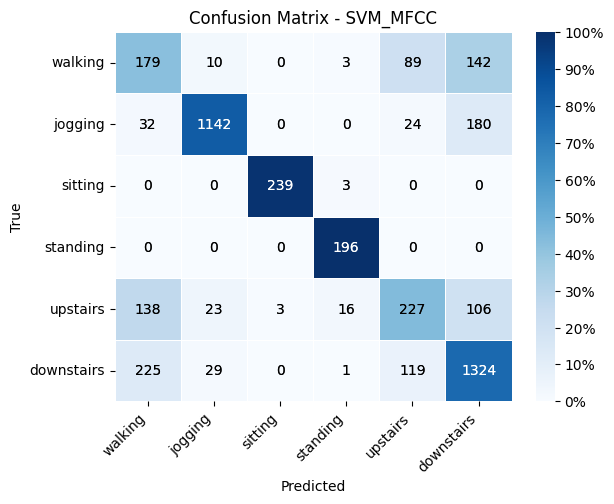

In [24]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by the true label counts
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with normalized colormap and absolute values
ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', xticklabels=activities, yticklabels=activities, linewidths=.5)

# Annotate with absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
        ax.text(j + 0.5, i + 0.5, format(cm[i, j], 'd'),
                ha='center', va='center', color=text_color)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([i/10.0 for i in range(11)])
colorbar.set_ticklabels([f'{i*10}%' for i in range(11)])

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees
plt.title("Confusion Matrix - SVM_MFCC")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### SVM - ZCR

In [25]:
X_train, X_val, X_test, y_train, y_val, y_test, X_train_mean, X_train_std = load_data(data, overlap=0.5, feature_extractor=zcr, standardize=True, reshape=True)

Axes means: [0.21829983 0.08840439 0.29499625]
Axes standard deviations: [0.1331094  0.1079593  0.13486926]


Save mean and standard deviation

In [ ]:
os.makedirs(base_path + 'training_data/SVM_zcr/', exist_ok=True)

with open(base_path + 'training_data/SVM_zcr/X_train_mean.pkl', 'wb') as f:
    pickle.dump(X_train_mean, f)

with open(base_path + 'training_data/SVM_zcr/X_train_std.pkl', 'wb') as f:
    pickle.dump(X_train_std, f)

In [ ]:
print(f"X_train shape: \t{X_train.shape},\tmin value: {X_train.min():.3f}, \tmax value: {X_train.max():.3f}")
print(f"y_train shape: \t{y_train.shape}")

print(f"X_val shape: \t{X_val.shape},\tmin value: {X_val.min():.3f}, \tmax value: {X_val.max():.3f}")
print(f"y_val shape: \t{y_val.shape}")

print(f"X_test shape: \t{X_test.shape},\tmin value: {X_test.min():.3f}, \tmax value: {X_test.max():.3f}")
print(f"y_test shape: \t{y_test.shape}")

X_train shape: 	(16019, 3),	min value: -2.187, 	max value: 4.739
y_train shape: 	(16019,)
X_val shape: 	(1780, 3),	min value: -2.187, 	max value: 4.368
y_val shape: 	(1780,)
X_test shape: 	(4450, 3),	min value: -2.187, 	max value: 5.109
y_test shape: 	(4450,)


In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
SVM_zcr = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
SVM_zcr = SVM_zcr.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 426.195s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(SVM_zcr.best_estimator_.C))
print(' gamma: '+str(SVM_zcr.best_estimator_.gamma))

Best parameters combination:
 C: 500
 gamma: 0.5


Saving the model

In [ ]:
# Ensure the directory exists
models_filepath = base_path + 'Models/'
os.makedirs(models_filepath, exist_ok=True)

# Save the trained SVM model
SVM_zcr_filepath = os.path.join(models_filepath, 'SVM_zcr_model.pkl')
with open(SVM_zcr_filepath, 'wb') as f:
    pickle.dump(SVM_zcr, f)

#### SVM_zcr Evaluation

Loading the model

In [26]:
models_filepath = base_path + 'Models/'
os.makedirs(models_filepath, exist_ok=True)

SVM_zcr_filepath = os.path.join(models_filepath, 'SVM_zcr_model.pkl')
with open(SVM_zcr_filepath, 'rb') as f:
    SVM_zcr = pickle.load(f)

ZCR Report

In [27]:
# SVM with ZCR test
y_pred = SVM_zcr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  downstairs       0.34      0.35      0.34       423
     jogging       0.94      0.94      0.94      1378
     sitting       0.64      0.96      0.77       242
    standing       0.45      0.30      0.36       196
    upstairs       0.40      0.44      0.42       513
     walking       0.81      0.74      0.77      1698

    accuracy                           0.73      4450
   macro avg       0.60      0.62      0.60      4450
weighted avg       0.73      0.73      0.73      4450



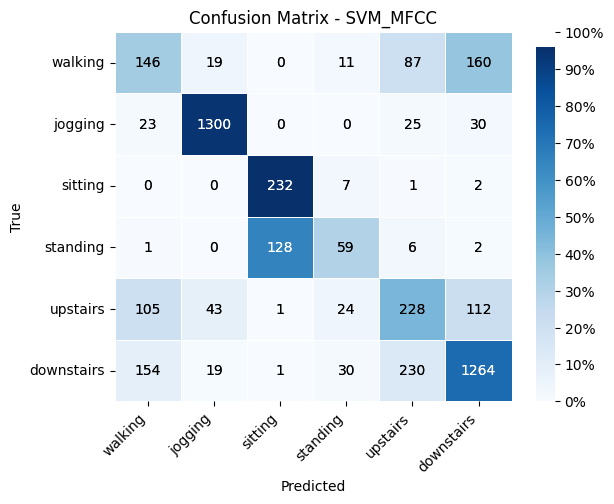

In [30]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by the true label counts
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with normalized colormap and absolute values
ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', xticklabels=activities, yticklabels=activities, linewidths=.5)

# Annotate with absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
        ax.text(j + 0.5, i + 0.5, format(cm[i, j], 'd'),
                ha='center', va='center', color=text_color)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([i/10.0 for i in range(11)])
colorbar.set_ticklabels([f'{i*10}%' for i in range(11)])

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees
plt.title("Confusion Matrix - SVM_MFCC")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### SVM - Combo (Energy; ZCR)

In [31]:
# Choose the feature extractor and modify the below 'load_data' function according to it
X_train, X_val, X_test, y_train, y_val, y_test, X_train_mean, X_train_std = load_data(data, feature_extractor=combo, overlap=0.5, standardize=True, reshape=True)

Axes means: [2436.90184393 5062.12166172 1191.34779445]
Axes standard deviations: [4626.74580971 6695.80337464 2261.02715039]


Save mean and standard deviation

In [ ]:
os.makedirs(base_path + 'training_data/SVM_combo/', exist_ok=True)

with open(base_path + 'training_data/SVM_combo/X_train_mean.pkl', 'wb') as f:
    pickle.dump(X_train_mean, f)

with open(base_path + 'training_data/SVM_combo/X_train_std.pkl', 'wb') as f:
    pickle.dump(X_train_std, f)

In [ ]:
print(f"X_train shape: \t{X_train.shape},\tmin value: {X_train.min():.3f}, \tmax value: {X_train.max():.3f}")
print(f"y_train shape: \t{y_train.shape}")

print(f"X_val shape: \t{X_val.shape},\tmin value: {X_val.min():.3f}, \tmax value: {X_val.max():.3f}")
print(f"y_val shape: \t{y_val.shape}")

print(f"X_test shape: \t{X_test.shape},\tmin value: {X_test.min():.3f}, \tmax value: {X_test.max():.3f}")
print(f"y_test shape: \t{y_test.shape}")

X_train shape: 	(16019, 6),	min value: -0.756, 	max value: 81.779
y_train shape: 	(16019,)
X_val shape: 	(1780, 6),	min value: -0.756, 	max value: 79.285
y_val shape: 	(1780,)
X_test shape: 	(4450, 6),	min value: -0.756, 	max value: 69.611
y_test shape: 	(4450,)


In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
SVM_combo = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
SVM_combo = SVM_combo.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 346.110s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(SVM_combo.best_estimator_.C))
print(' gamma: '+str(SVM_combo.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 1.0


Saving the model

In [ ]:
# Ensure the directory exists
models_filepath = base_path + 'Models/'
os.makedirs(models_filepath, exist_ok=True)

# Save the trained SVM model
SVM_combo_filepath = os.path.join(models_filepath, 'SVM_combo_model.pkl')
with open(SVM_combo_filepath, 'wb') as f:
    pickle.dump(SVM_combo, f)

#### SVM_combo Evaluation

Loading the model

In [32]:
models_filepath = base_path + 'Models/'
os.makedirs(models_filepath, exist_ok=True)

SVM_combo_filepath = os.path.join(models_filepath, 'SVM_combo_model.pkl')
with open(SVM_combo_filepath, 'rb') as f:
    SVM_combo = pickle.load(f)

In [33]:
# SVM test
y_pred = SVM_combo.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  downstairs       0.34      0.53      0.41       423
     jogging       0.95      0.84      0.89      1378
     sitting       0.99      0.99      0.99       242
    standing       0.92      1.00      0.96       196
    upstairs       0.51      0.49      0.50       513
     walking       0.78      0.74      0.76      1698

    accuracy                           0.75      4450
   macro avg       0.75      0.77      0.75      4450
weighted avg       0.78      0.75      0.76      4450



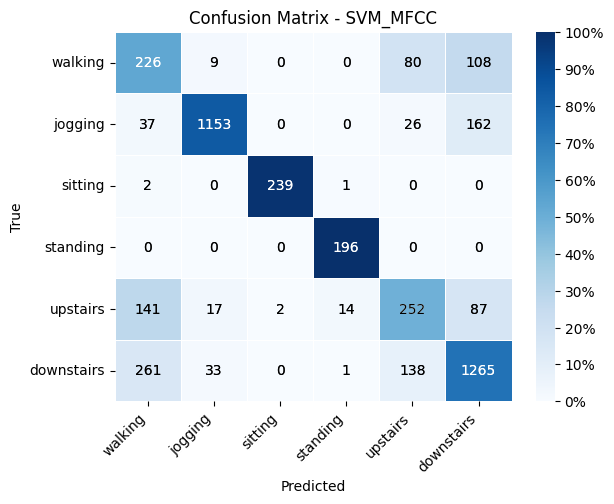

In [34]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by the true label counts
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with normalized colormap and absolute values
ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', xticklabels=activities, yticklabels=activities, linewidths=.5)

# Annotate with absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
        ax.text(j + 0.5, i + 0.5, format(cm[i, j], 'd'),
                ha='center', va='center', color=text_color)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([i/10.0 for i in range(11)])
colorbar.set_ticklabels([f'{i*10}%' for i in range(11)])

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees
plt.title("Confusion Matrix - SVM_MFCC")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### SVM - FFT

In [35]:
# Choose the feature extractor and modify the below 'load_data' function according to it
X_train, X_val, X_test, y_train, y_val, y_test, X_train_mean, X_train_std = load_data(data, feature_extractor=feats_fourier, overlap=0.5, standardize=True, reshape=True)

Axes means: [ 1.47035676 14.44099681  0.84820117]
Axes standard deviations: [ 73.54036185 121.46165731  44.23965616]


Save mean and standard deviation

In [ ]:
os.makedirs(base_path + 'training_data/SVM_fft/', exist_ok=True)

with open(base_path + 'training_data/SVM_fft/X_train_mean.pkl', 'wb') as f:
    pickle.dump(X_train_mean, f)

with open(base_path + 'training_data/SVM_fft/X_train_std.pkl', 'wb') as f:
    pickle.dump(X_train_std, f)

In [ ]:
print(f"X_train shape: \t{X_train.shape},\tmin value: {X_train.min():.3f}, \tmax value: {X_train.max():.3f}")
print(f"y_train shape: \t{y_train.shape}")

print(f"X_val shape: \t{X_val.shape},\tmin value: {X_val.min():.3f}, \tmax value: {X_val.max():.3f}")
print(f"y_val shape: \t{y_val.shape}")

print(f"X_test shape: \t{X_test.shape},\tmin value: {X_test.min():.3f}, \tmax value: {X_test.max():.3f}")
print(f"y_test shape: \t{y_test.shape}")

X_train shape: 	(16019, 153),	min value: -30.192, 	max value: 66.554
y_train shape: 	(16019,)
X_val shape: 	(1780, 153),	min value: -17.564, 	max value: 61.581
y_val shape: 	(1780,)
X_test shape: 	(4450, 153),	min value: -36.437, 	max value: 41.854
y_test shape: 	(4450,)


In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
SVM_fft = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
SVM_fft = SVM_fft.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 962.874s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(SVM_fft.best_estimator_.C))
print(' gamma: '+str(SVM_fft.best_estimator_.gamma))

Best parameters combination:
 C: 100
 gamma: 0.01


Saving the model

In [ ]:
# Ensure the directory exists
models_filepath = base_path + 'Models/'
os.makedirs(models_filepath, exist_ok=True)

# Save the trained SVM model
SVM_fft_filepath = os.path.join(models_filepath, 'SVM_fft_model.pkl')
with open(SVM_fft_filepath, 'wb') as f:
    pickle.dump(SVM_fft, f)

#### SVM_fft Evaluation

Loading the model

In [36]:
models_filepath = base_path + 'Models/'
os.makedirs(models_filepath, exist_ok=True)

SVM_fft_filepath = os.path.join(models_filepath, 'SVM_fft_model.pkl')
with open(SVM_fft_filepath, 'rb') as f:
    SVM_fft = pickle.load(f)

In [37]:
# SVM test
y_pred = SVM_fft.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  downstairs       0.69      0.63      0.66       423
     jogging       0.95      0.97      0.96      1378
     sitting       0.99      0.99      0.99       242
    standing       0.97      1.00      0.98       196
    upstairs       0.75      0.64      0.69       513
     walking       0.92      0.96      0.94      1698

    accuracy                           0.90      4450
   macro avg       0.88      0.86      0.87      4450
weighted avg       0.89      0.90      0.89      4450



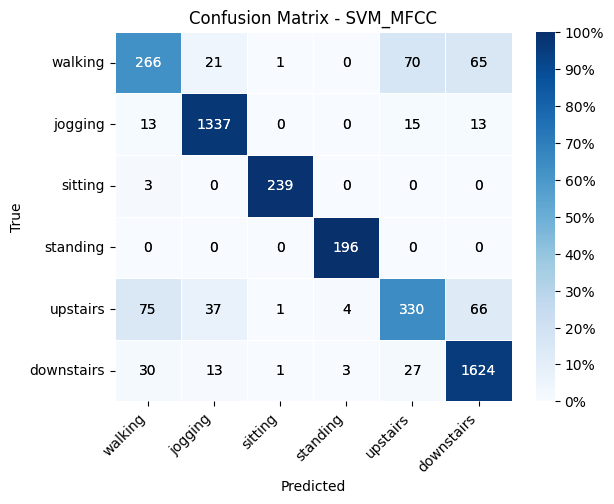

In [38]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by the true label counts
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with normalized colormap and absolute values
ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', xticklabels=activities, yticklabels=activities, linewidths=.5)

# Annotate with absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
        ax.text(j + 0.5, i + 0.5, format(cm[i, j], 'd'),
                ha='center', va='center', color=text_color)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([i/10.0 for i in range(11)])
colorbar.set_ticklabels([f'{i*10}%' for i in range(11)])

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees
plt.title("Confusion Matrix - SVM_MFCC")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### SVM - Spectrogram

In [39]:
# Choose the feature extractor and modify the below 'load_data' function according to it
X_train, X_val, X_test, y_train, y_val, y_test, X_train_mean, X_train_std = load_data(data, feature_extractor=feats_spectrogram, overlap=0.5, standardize=True, reshape=True)

Axes means: [2.70905338 3.20761005 1.76805247]
Axes standard deviations: [11.1453205  14.25911403  5.52218847]


Save mean and standard deviation

In [ ]:
os.makedirs(base_path + 'training_data/SVM_spectrogram/', exist_ok=True)

with open(base_path + 'training_data/SVM_spectrogram/X_train_mean.pkl', 'wb') as f:
    pickle.dump(X_train_mean, f)

with open(base_path + 'training_data/SVM_spectrogram/X_train_std.pkl', 'wb') as f:
    pickle.dump(X_train_std, f)

In [ ]:
print(f"X_train shape: \t{X_train.shape},\tmin value: {X_train.min():.3f}, \tmax value: {X_train.max():.3f}")
print(f"y_train shape: \t{y_train.shape}")

print(f"X_val shape: \t{X_val.shape},\tmin value: {X_val.min():.3f}, \tmax value: {X_val.max():.3f}")
print(f"y_val shape: \t{y_val.shape}")

print(f"X_test shape: \t{X_test.shape},\tmin value: {X_test.min():.3f}, \tmax value: {X_test.max():.3f}")
print(f"y_test shape: \t{y_test.shape}")

X_train shape: 	(16019, 99),	min value: -0.320, 	max value: 284.983
y_train shape: 	(16019,)
X_val shape: 	(1780, 99),	min value: -0.320, 	max value: 519.348
y_val shape: 	(1780,)
X_test shape: 	(4450, 99),	min value: -0.320, 	max value: 688.683
y_test shape: 	(4450,)


In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
SVM_spectrogram = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
SVM_spectrogram = SVM_spectrogram.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 303.886s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(SVM_spectrogram.best_estimator_.C))
print(' gamma: '+str(SVM_spectrogram.best_estimator_.gamma))

Best parameters combination:
 C: 100
 gamma: 0.1


Saving the model

In [ ]:
# Ensure the directory exists
models_filepath = base_path + 'Models/'
os.makedirs(models_filepath, exist_ok=True)

# Save the trained SVM model
SVM_spectrogram_filepath = os.path.join(models_filepath, 'SVM_spectrogram_model.pkl')
with open(SVM_spectrogram_filepath, 'wb') as f:
    pickle.dump(SVM_spectrogram, f)

#### SVM_spectrogram Evaluation

Loading the model

In [40]:
models_filepath = base_path + 'Models/'
os.makedirs(models_filepath, exist_ok=True)

SVM_spectrogram_filepath = os.path.join(models_filepath, 'SVM_spectrogram_model.pkl')
with open(SVM_spectrogram_filepath, 'rb') as f:
    SVM_spectrogram = pickle.load(f)

In [41]:
# SVM test
y_pred = SVM_spectrogram.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  downstairs       0.86      0.85      0.86       423
     jogging       0.95      0.99      0.97      1378
     sitting       0.60      0.98      0.74       242
    standing       0.90      0.19      0.32       196
    upstairs       0.89      0.81      0.85       513
     walking       0.98      0.97      0.98      1698

    accuracy                           0.91      4450
   macro avg       0.86      0.80      0.79      4450
weighted avg       0.92      0.91      0.91      4450



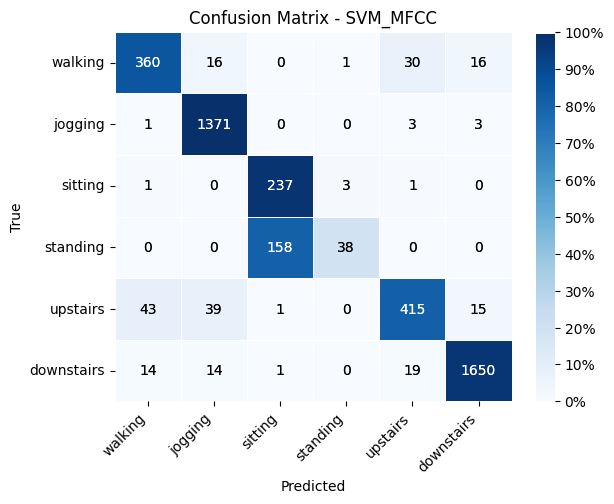

In [42]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by the true label counts
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with normalized colormap and absolute values
ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', xticklabels=activities, yticklabels=activities, linewidths=.5)

# Annotate with absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
        ax.text(j + 0.5, i + 0.5, format(cm[i, j], 'd'),
                ha='center', va='center', color=text_color)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([i/10.0 for i in range(11)])
colorbar.set_ticklabels([f'{i*10}%' for i in range(11)])

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees
plt.title("Confusion Matrix - SVM_MFCC")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### SVM - Mel

In [ ]:
# Choose the feature extractor and modify the below 'load_data' function according to it
X_train, X_val, X_test, y_train, y_val, y_test, X_train_mean, X_train_std = load_data(data, feature_extractor=feats_mel, overlap=0.5, standardize=True, reshape=True)

Axes means: [2060.49644121 2981.27626793 1234.49557616]
Axes standard deviations: [5713.55090082 6928.86683987 2802.10719685]


Save mean and standard deviation

In [ ]:
os.makedirs(base_path + 'training_data/SVM_mel/', exist_ok=True)

with open(base_path + 'training_data/SVM_mel/X_train_mean.pkl', 'wb') as f:
    pickle.dump(X_train_mean, f)

with open(base_path + 'training_data/SVM_mel/X_train_std.pkl', 'wb') as f:
    pickle.dump(X_train_std, f)

In [ ]:
print(f"X_train shape: \t{X_train.shape},\tmin value: {X_train.min():.3f}, \tmax value: {X_train.max():.3f}")
print(f"y_train shape: \t{y_train.shape}")

print(f"X_val shape: \t{X_val.shape},\tmin value: {X_val.min():.3f}, \tmax value: {X_val.max():.3f}")
print(f"y_val shape: \t{y_val.shape}")

print(f"X_test shape: \t{X_test.shape},\tmin value: {X_test.min():.3f}, \tmax value: {X_test.max():.3f}")
print(f"y_test shape: \t{y_test.shape}")

X_train shape: 	(16019, 120),	min value: -0.441, 	max value: 335.886
y_train shape: 	(16019,)
X_val shape: 	(1780, 120),	min value: -0.441, 	max value: 211.604
y_val shape: 	(1780,)
X_test shape: 	(4450, 120),	min value: -0.441, 	max value: 284.013
y_test shape: 	(4450,)


In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
SVM_mel = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
SVM_mel = SVM_mel.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 370.750s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(SVM_mel.best_estimator_.C))
print(' gamma: '+str(SVM_mel.best_estimator_.gamma))

Best parameters combination:
 C: 100
 gamma: 0.1


Saving the model

In [ ]:
# Ensure the directory exists
models_filepath = base_path + 'Models/'
os.makedirs(models_filepath, exist_ok=True)

# Save the trained SVM model
SVM_mel_filepath = os.path.join(models_filepath, 'SVM_mel_model.pkl')
with open(SVM_mel_filepath, 'wb') as f:
    pickle.dump(SVM_mel, f)

#### SVM_mel Evaluation

Loading the model

In [ ]:
models_filepath = base_path + 'Models/'
os.makedirs(models_filepath, exist_ok=True)

SVM_mel_filepath = os.path.join(models_filepath, 'SVM_mel_model.pkl')
with open(SVM_mel_filepath, 'rb') as f:
    SVM_mel = pickle.load(f)

In [ ]:
# SVM test
y_pred = SVM_mel.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  downstairs       0.88      0.83      0.86       423
     jogging       0.94      0.99      0.96      1378
     sitting       1.00      0.97      0.98       242
    standing       0.96      1.00      0.98       196
    upstairs       0.91      0.84      0.88       513
     walking       0.98      0.97      0.97      1698

    accuracy                           0.95      4450
   macro avg       0.94      0.93      0.94      4450
weighted avg       0.95      0.95      0.95      4450



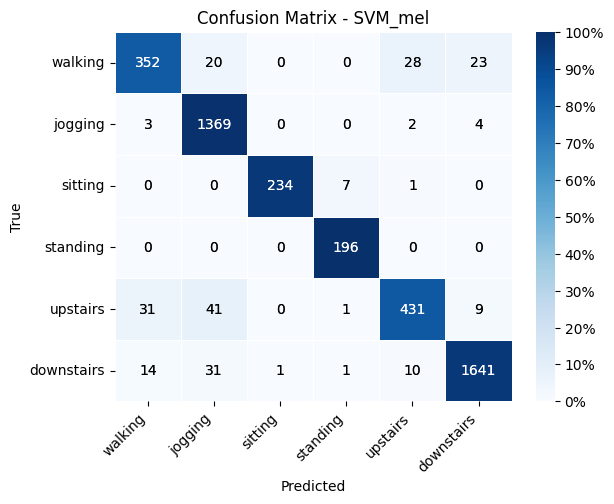

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by the true label counts
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with normalized colormap and absolute values
ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', xticklabels=activities, yticklabels=activities, linewidths=.5)

# Annotate with absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
        ax.text(j + 0.5, i + 0.5, format(cm[i, j], 'd'),
                ha='center', va='center', color=text_color)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([i/10.0 for i in range(11)])
colorbar.set_ticklabels([f'{i*10}%' for i in range(11)])

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees
plt.title("Confusion Matrix - SVM_mel")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### SVM - MFCC

In [ ]:
# Choose the feature extractor and modify the below 'load_data' function according to it
X_train, X_val, X_test, y_train, y_val, y_test, X_train_mean, X_train_std = load_data(data, feature_extractor=feats_mfcc, overlap=0.5, standardize=True, reshape=True)

Axes means: [10.01352122 11.63728754  8.92102375]
Axes standard deviations: [26.10861445 27.44269014 25.6390238 ]


Save mean and standard deviation

In [ ]:
os.makedirs(base_path + 'training_data/SVM_MFCC/', exist_ok=True)

with open(base_path + 'training_data/SVM_MFCC/X_train_mean.pkl', 'wb') as f:
    pickle.dump(X_train_mean, f)

with open(base_path + 'training_data/SVM_MFCC/X_train_std.pkl', 'wb') as f:
    pickle.dump(X_train_std, f)

In [ ]:
print(f"X_train shape: \t{X_train.shape},\tmin value: {X_train.min():.3f}, \tmax value: {X_train.max():.3f}")
print(f"y_train shape: \t{y_train.shape}")

print(f"X_val shape: \t{X_val.shape},\tmin value: {X_val.min():.3f}, \tmax value: {X_val.max():.3f}")
print(f"y_val shape: \t{y_val.shape}")

print(f"X_test shape: \t{X_test.shape},\tmin value: {X_test.min():.3f}, \tmax value: {X_test.max():.3f}")
print(f"y_test shape: \t{y_test.shape}")

X_train shape: 	(16019, 120),	min value: -2.679, 	max value: 4.983
y_train shape: 	(16019,)
X_val shape: 	(1780, 120),	min value: -2.239, 	max value: 4.379
y_val shape: 	(1780,)
X_test shape: 	(4450, 120),	min value: -2.541, 	max value: 4.503
y_test shape: 	(4450,)


In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
SVM_MFCC = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
SVM_MFCC = SVM_MFCC.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 279.337s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(SVM_MFCC.best_estimator_.C))
print(' gamma: '+str(SVM_MFCC.best_estimator_.gamma))

Best parameters combination:
 C: 100
 gamma: 0.5


Saving the model

In [ ]:
# Ensure the directory exists
models_filepath = base_path + 'Models/'
os.makedirs(models_filepath, exist_ok=True)

# Save the trained SVM model
SVM_MFCC_filepath = os.path.join(models_filepath, 'SVM_MFCC_model.pkl')
with open(SVM_MFCC_filepath, 'wb') as f:
    pickle.dump(SVM_MFCC, f)

#### SVM_MFCC Evaluation

Loading the model

In [ ]:
models_filepath = base_path + 'Models/'
os.makedirs(models_filepath, exist_ok=True)

SVM_MFCC_filepath = os.path.join(models_filepath, 'SVM_MFCC_model.pkl')
with open(SVM_MFCC_filepath, 'rb') as f:
    SVM_MFCC = pickle.load(f)

In [ ]:
# SVM test
y_pred = SVM_MFCC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  downstairs       0.88      0.85      0.87       423
     jogging       0.98      0.99      0.99      1378
     sitting       1.00      0.98      0.99       242
    standing       0.98      1.00      0.99       196
    upstairs       0.91      0.87      0.89       513
     walking       0.97      0.98      0.98      1698

    accuracy                           0.96      4450
   macro avg       0.95      0.95      0.95      4450
weighted avg       0.96      0.96      0.96      4450



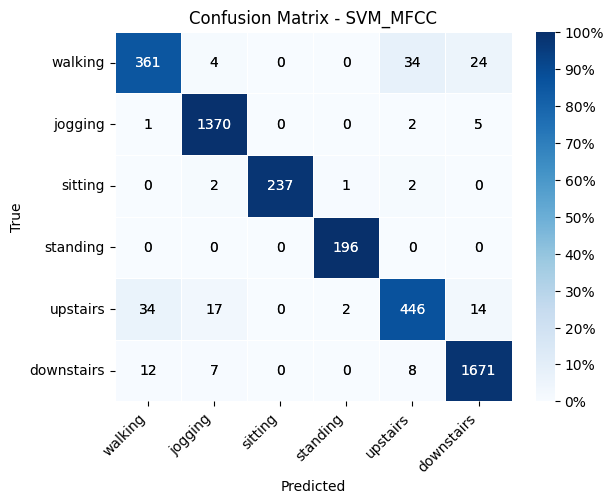

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by the true label counts
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with normalized colormap and absolute values
ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', xticklabels=activities, yticklabels=activities, linewidths=.5)

# Annotate with absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
        ax.text(j + 0.5, i + 0.5, format(cm[i, j], 'd'),
                ha='center', va='center', color=text_color)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([i/10.0 for i in range(11)])
colorbar.set_ticklabels([f'{i*10}%' for i in range(11)])

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees
plt.title("Confusion Matrix - SVM_MFCC")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## LSTM1

The first LSTM (Long short-term memory) is a simple one: it has a single LSTM layer with 32 units and a dense layer with softmax activation that generates output probabilities for each of the 6 activities

### LSTM1 - Data Preparation

In [44]:
X_train, X_val, X_test, y_train, y_val, y_test, X_train_mean, X_train_std = load_data(data, overlap=0.5, dummy=True, feature_extractor=identity, standardize=True, reshape = False)

Axes means: [0.78800292 7.3595822  0.44801032]
Axes standard deviations: [6.98894047 6.8522155  4.8944188 ]


Save mean and std deviation

In [46]:
os.makedirs(base_path + 'training_data/LSTM1/', exist_ok=True)

with open(base_path + 'training_data/LSTM1/X_train_mean.pkl', 'wb') as f:
    pickle.dump(X_train_mean, f)

with open(base_path + 'training_data/LSTM1/X_train_std.pkl', 'wb') as f:
    pickle.dump(X_train_std, f)

In [ ]:
print(f"X_train shape: \t{X_train.shape},\tmin value: {X_train.min():.3f}, \tmax value: {X_train.max():.3f}")
print(f"y_train shape: \t{y_train.shape}")

print(f"X_val shape: \t{X_val.shape},\t\tmin value: {X_val.min():.3f}, \tmax value: {X_val.max():.3f}")
print(f"y_val shape: \t{y_val.shape}")

print(f"X_test shape: \t{X_test.shape},\t\tmin value: {X_test.min():.3f}, \tmax value: {X_test.max():.3f}")
print(f"y_test shape: \t{y_test.shape}")

X_train shape: 	(16019, 3, 100),	min value: -17.045, 	max value: 17.301
y_train shape: 	(16019, 6)
X_val shape: 	(1780, 3, 100),		min value: -8.662, 	max value: 11.796
y_val shape: 	(1780, 6)
X_test shape: 	(4450, 3, 100),		min value: -12.093, 	max value: 10.753
y_test shape: 	(4450, 6)


In [ ]:
X_train = X_train.transpose(0, 2, 1)
X_val = X_val.transpose(0, 2, 1)
X_test = X_test.transpose(0, 2, 1)

In [ ]:
print(f"X_train shape: \t{X_train.shape},\tmin value: {X_train.min():.3f}, \tmax value: {X_train.max():.3f}")
print(f"y_train shape: \t{y_train.shape}")

print(f"X_val shape: \t{X_val.shape},\t\tmin value: {X_val.min():.3f}, \tmax value: {X_val.max():.3f}")
print(f"y_val shape: \t{y_val.shape}")

print(f"X_test shape: \t{X_test.shape},\t\tmin value: {X_test.min():.3f}, \tmax value: {X_test.max():.3f}")
print(f"y_test shape: \t{y_test.shape}")

X_train shape: 	(16019, 100, 3),	min value: -17.045, 	max value: 17.301
y_train shape: 	(16019, 6)
X_val shape: 	(1780, 100, 3),		min value: -8.662, 	max value: 11.796
y_val shape: 	(1780, 6)
X_test shape: 	(4450, 100, 3),		min value: -12.093, 	max value: 10.753
y_test shape: 	(4450, 6)


### LSTM1 - Definition

In [ ]:
input_shape = (X_train.shape[1:])
num_classes = y_train.shape[1]
print(f"Input shape:\t\t{input_shape}\nNumber of classes:\t{num_classes}")

Input shape:		(100, 3)
Number of classes:	6


In [ ]:
def create_model(input_shape, num_classes):
    input_layer = keras.layers.Input(shape=(100, 3))

    x = keras.layers.LSTM(32, return_sequences=False)(input_layer)

    # Dense layer
    output_layer = keras.layers.Dense(len(activities), activation='softmax')(x)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer, name = 'LSTM1')
    return model

In [ ]:
LSTM1 = create_model(input_shape, num_classes)
LSTM1.summary()

Model: "LSTM1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                4608      
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 4806 (18.77 KB)
Trainable params: 4806 (18.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### LSTM1 - Parameters and Callbacks

In [ ]:
# Hyperparameters
lr = 0.001
epochs = 100
batch_size = 64

# Optimizer, Loss and Metrics
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_function = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']

Callbacks

In [ ]:
# Reduce Learning Rate On Plateau
callback_rp = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.5,
                                                patience=5,
                                                min_lr=1e-8,
                                                verbose=1)

# Early Stopping
callback_es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True,
                                            verbose=1)

# Model Checkpoint
LSTM1_checkpoint_filepath = base_path + 'Models/LSTM1_checkpoint.keras'
callback_cp = keras.callbacks.ModelCheckpoint(LSTM1_checkpoint_filepath,
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              verbose=1
                                              )

# Backup and Restore
callback_br = keras.callbacks.BackupAndRestore(backup_dir = base_path + "backup/LSTM1")

# CSV Logger for history saving
history_LSTM1_filepath = base_path + 'backup/history_LSTM1.csv'
callback_CVS = keras.callbacks.CSVLogger(history_LSTM1_filepath, separator=",", append=True)

callbacks = [callback_rp, callback_es, callback_cp, callback_br, callback_CVS]

Compile the model

In [ ]:
LSTM1.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

### LSTM1 - Training

In [ ]:
# Train the model
history_LSTM1 = LSTM1.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(X_val, y_val),
                          callbacks=callbacks)

Epoch 1/100
245/251 [============================>.] - ETA: 0s - loss: 1.2268 - accuracy: 0.5727
Epoch 1: val_loss improved from inf to 0.99975, saving model to /content/drive/MyDrive/DSaIM_project/1D/Models/LSTM1_checkpoint.keras
251/251 [==============================] - 4s 9ms/step - loss: 1.2222 - accuracy: 0.5745 - val_loss: 0.9998 - val_accuracy: 0.6573 - lr: 0.0010
Epoch 2/100
251/251 [==============================] - ETA: 0s - loss: 0.9259 - accuracy: 0.6942
Epoch 2: val_loss improved from 0.99975 to 0.81562, saving model to /content/drive/MyDrive/DSaIM_project/1D/Models/LSTM1_checkpoint.keras
251/251 [==============================] - 2s 9ms/step - loss: 0.9259 - accuracy: 0.6942 - val_loss: 0.8156 - val_accuracy: 0.7242 - lr: 0.0010
Epoch 3/100
249/251 [============================>.] - ETA: 0s - loss: 0.7962 - accuracy: 0.7332
Epoch 3: val_loss improved from 0.81562 to 0.79705, saving model to /content/drive/MyDrive/DSaIM_project/1D/Models/LSTM1_checkpoint.keras
251/251 [==

In [ ]:
# Load the CSV file
history_df = pd.read_csv(history_LSTM1_filepath)

In [ ]:
best_epoch = history_df['val_loss'].idxmin()
best_val_loss = history_df['val_loss'].min()
best_val_accuracy = history_df['val_accuracy'].iloc[best_epoch]

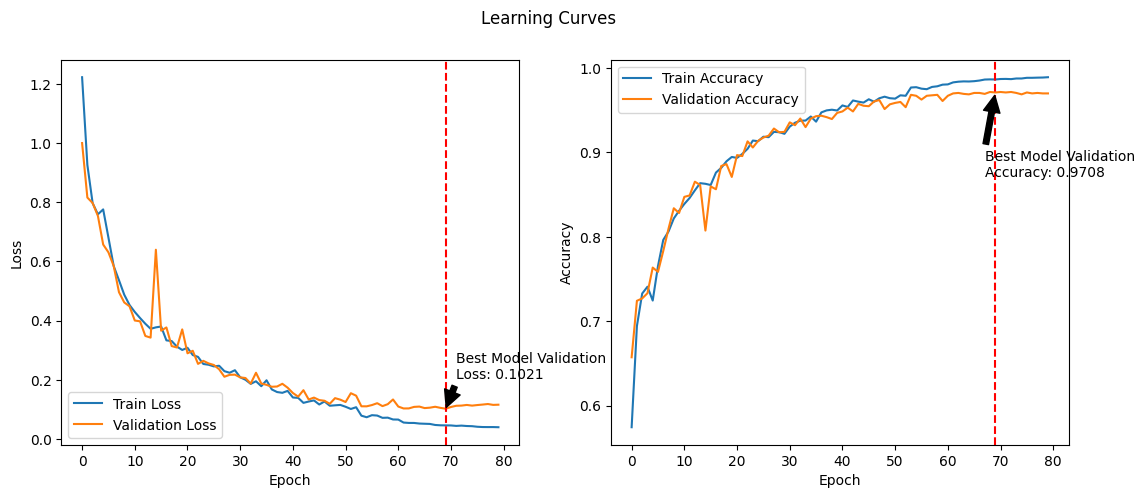

In [ ]:
plt.figure(figsize=(13, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Vertical line at the best epoch
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (epoch {best_epoch})')

# Add text annotation for the best validation loss
plt.annotate(f'Best Model Validation\nLoss: {best_val_loss:.4f}',
             xy=(best_epoch, best_val_loss),
             xytext=(best_epoch + 2, best_val_loss + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (epoch {best_epoch})')

# Add text annotation for the best validation loss
plt.annotate(f'Best Model Validation\nAccuracy: {best_val_accuracy:.4f}',
             xy=(best_epoch, best_val_accuracy),
             xytext=(best_epoch - 2, best_val_accuracy - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.suptitle('Learning Curves')
plt.show()

### LSTM1 - Evaluation

In [ ]:
# Load the model
LSTM1_checkpoint_filepath = base_path + 'Models/LSTM1_checkpoint.keras'
LSTM1 = keras.models.load_model(LSTM1_checkpoint_filepath)

# Evaluate the loaded model
loss, acc = LSTM1.evaluate(X_test, y_test)
print(f"LSTM1 accuracy on test data: {acc * 100:.2f}%")

140/140 [==============================] - 3s 12ms/step - loss: 0.0859 - accuracy: 0.9757
LSTM1 accuracy on test data: 97.57%


In [ ]:
# Predict the probabilities for the test data
y_pred_prob = LSTM1.predict(X_test)

140/140 [==============================] - 2s 11ms/step


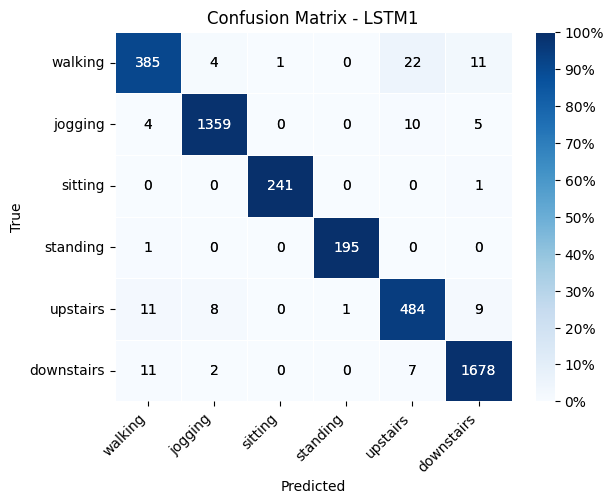

In [ ]:
# Convert predictions and true labels to integer labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix by the true label counts
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with normalized colormap and absolute values
ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', xticklabels=activities, yticklabels=activities, linewidths=.5)

# Annotate with absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
        ax.text(j + 0.5, i + 0.5, format(cm[i, j], 'd'),
                ha='center', va='center', color=text_color)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([i/10.0 for i in range(11)])
colorbar.set_ticklabels([f'{i*10}%' for i in range(11)])

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees
plt.title("Confusion Matrix - LSTM1")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## LSTM2

The second LSTM model builds upon the previous one by incorporating multiple LSTM layers and additional regularization techniques. It includes three stacked LSTM layers, each with 128 units and followed by batch normalization and dropout layers to prevent overfitting.

### LSTM2 - Data Preparation

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, X_train_mean, X_train_std = load_data(data, overlap=0.5, dummy=True, feature_extractor=identity, standardize=True, reshape = False)

Axes means: [0.78800292 7.3595822  0.44801032]
Axes standard deviations: [6.98894047 6.8522155  4.8944188 ]


In [ ]:
os.makedirs(base_path + 'training_data/LSTM2/', exist_ok=True)

with open(base_path + 'training_data/LSTM2/X_train_mean.pkl', 'wb') as f:
    pickle.dump(X_train_mean, f)

with open(base_path + 'training_data/LSTM2/X_train_std.pkl', 'wb') as f:
    pickle.dump(X_train_std, f)

In [ ]:
print(f"X_train shape: \t{X_train.shape},\tmin value: {X_train.min():.3f}, \tmax value: {X_train.max():.3f}")
print(f"y_train shape: \t{y_train.shape}")

print(f"X_val shape: \t{X_val.shape},\t\tmin value: {X_val.min():.3f}, \tmax value: {X_val.max():.3f}")
print(f"y_val shape: \t{y_val.shape}")

print(f"X_test shape: \t{X_test.shape},\t\tmin value: {X_test.min():.3f}, \tmax value: {X_test.max():.3f}")
print(f"y_test shape: \t{y_test.shape}")

X_train shape: 	(16019, 3, 100),	min value: -17.045, 	max value: 17.301
y_train shape: 	(16019, 6)
X_val shape: 	(1780, 3, 100),		min value: -8.662, 	max value: 11.796
y_val shape: 	(1780, 6)
X_test shape: 	(4450, 3, 100),		min value: -12.093, 	max value: 10.753
y_test shape: 	(4450, 6)


In [ ]:
X_train = X_train.transpose(0, 2, 1)
X_val = X_val.transpose(0, 2, 1)
X_test = X_test.transpose(0, 2, 1)

In [ ]:
print(f"X_train shape: \t{X_train.shape},\tmin value: {X_train.min():.3f}, \tmax value: {X_train.max():.3f}")
print(f"y_train shape: \t{y_train.shape}")

print(f"X_val shape: \t{X_val.shape},\t\tmin value: {X_val.min():.3f}, \tmax value: {X_val.max():.3f}")
print(f"y_val shape: \t{y_val.shape}")

print(f"X_test shape: \t{X_test.shape},\t\tmin value: {X_test.min():.3f}, \tmax value: {X_test.max():.3f}")
print(f"y_test shape: \t{y_test.shape}")

X_train shape: 	(16019, 100, 3),	min value: -17.045, 	max value: 17.301
y_train shape: 	(16019, 6)
X_val shape: 	(1780, 100, 3),		min value: -8.662, 	max value: 11.796
y_val shape: 	(1780, 6)
X_test shape: 	(4450, 100, 3),		min value: -12.093, 	max value: 10.753
y_test shape: 	(4450, 6)


In [ ]:
input_shape = (X_train.shape[1:])
num_classes = y_train.shape[1]
print(f"Input shape:\t\t{input_shape}\nNumber of classes:\t{num_classes}")

Input shape:		(100, 3)
Number of classes:	6


### LSTM2 - Definition

In [ ]:
def create_model(input_shape, num_classes):
    input_layer = keras.layers.Input(shape=(100, 3))

    # First LSTM layer with batch normalization
    x = keras.layers.LSTM(128, return_sequences=True)(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)

    # Second LSTM layer with batch normalization
    x = keras.layers.LSTM(128, return_sequences=True)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)

    # Third LSTM layer with batch normalization
    x = keras.layers.LSTM(128, return_sequences=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)

    # Dense layer for classification
    output_layer = keras.layers.Dense(len(activities), activation='softmax')(x)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer, name = 'LSTM2')
    return model

In [ ]:
LSTM2 = create_model(input_shape, num_classes)
LSTM2.summary()

Model: "LSTM2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 lstm (LSTM)                 (None, 100, 128)          67584     
                                                                 
 batch_normalization (Batch  (None, 100, 128)          512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 128)          131584    
                                                                 
 batch_normalization_1 (Bat  (None, 100, 128)          512       
 chNormalization)                                            

### LSTM2 - Parameters and Callbacks

In [ ]:
# Hyperparameters
lr = 0.001
epochs = 100
batch_size = 64

# Optimizer, Loss and Metrics
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_function = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']

Callbacks

In [ ]:
# Reduce Learning Rate On Plateau
callback_rp = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.5,
                                                patience=5,
                                                min_lr=1e-8,
                                                verbose=1)

# Early Stopping
callback_es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True,
                                            verbose=1)

# Model Checkpoint
LSTM2_checkpoint_filepath = base_path + 'Models/LSTM2_checkpoint.keras'
callback_cp = keras.callbacks.ModelCheckpoint(LSTM2_checkpoint_filepath,
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              verbose=1
                                              )

# Backup and Restore
callback_br = keras.callbacks.BackupAndRestore(backup_dir = base_path + "backup/LSTM2")

# CSV Logger for history saving
history_LSTM2_filepath = base_path + 'backup/history_LSTM2.csv'
callback_CVS = keras.callbacks.CSVLogger(history_LSTM2_filepath, separator=",", append=True)

callbacks = [callback_rp, callback_es, callback_cp, callback_br, callback_CVS]

Compile the model

In [ ]:
LSTM2.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

### LSTM2 - Training

In [ ]:
# Train the model
history_LSTM2 = LSTM2.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(X_val, y_val),
                          callbacks=callbacks)

Epoch 1/100
250/251 [============================>.] - ETA: 0s - loss: 1.0610 - accuracy: 0.6621
Epoch 1: val_loss improved from inf to 1.08411, saving model to /content/drive/MyDrive/DSaIM_project/1D/Models/LSTM2_checkpoint.keras
251/251 [==============================] - 16s 26ms/step - loss: 1.0604 - accuracy: 0.6623 - val_loss: 1.0841 - val_accuracy: 0.7185 - lr: 0.0010
Epoch 2/100
251/251 [==============================] - ETA: 0s - loss: 0.5716 - accuracy: 0.8042
Epoch 2: val_loss improved from 1.08411 to 0.57876, saving model to /content/drive/MyDrive/DSaIM_project/1D/Models/LSTM2_checkpoint.keras
251/251 [==============================] - 5s 21ms/step - loss: 0.5716 - accuracy: 0.8042 - val_loss: 0.5788 - val_accuracy: 0.8022 - lr: 0.0010
Epoch 3/100
251/251 [==============================] - ETA: 0s - loss: 0.3730 - accuracy: 0.8788
Epoch 3: val_loss improved from 0.57876 to 0.20616, saving model to /content/drive/MyDrive/DSaIM_project/1D/Models/LSTM2_checkpoint.keras
251/251 

In [ ]:
# Load the CSV file
history_df = pd.read_csv(history_LSTM2_filepath)

In [ ]:
best_epoch = history_df['val_loss'].idxmin()
best_val_loss = history_df['val_loss'].min()
best_val_accuracy = history_df['val_accuracy'].iloc[best_epoch]

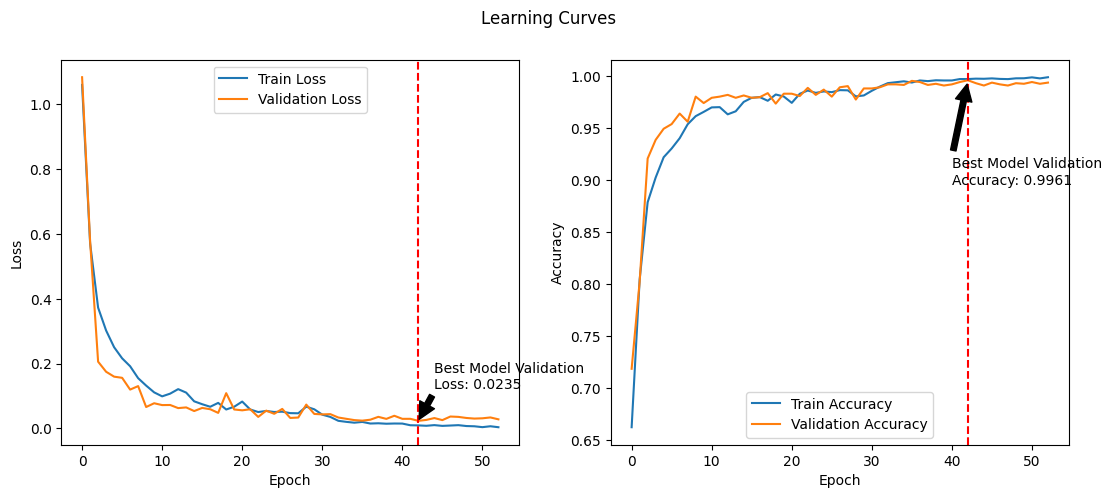

In [ ]:
plt.figure(figsize=(13, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Vertical line at the best epoch
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (epoch {best_epoch})')

# Add text annotation for the best validation loss
plt.annotate(f'Best Model Validation\nLoss: {best_val_loss:.4f}',
             xy=(best_epoch, best_val_loss),
             xytext=(best_epoch + 2, best_val_loss + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (epoch {best_epoch})')

# Add text annotation for the best validation loss
plt.annotate(f'Best Model Validation\nAccuracy: {best_val_accuracy:.4f}',
             xy=(best_epoch, best_val_accuracy),
             xytext=(best_epoch - 2, best_val_accuracy - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.suptitle('Learning Curves')
plt.show()

### LSTM2 - Evaluation

In [ ]:
# Load the model
LSTM2_checkpoint_filepath = base_path + 'Models/LSTM2_checkpoint.keras'
LSTM2 = keras.models.load_model(LSTM2_checkpoint_filepath)

# Verify the loaded model
loss, acc = LSTM2.evaluate(X_test, y_test)
print(f"LSTM2 accuracy on test data: {acc * 100:.2f}%")

140/140 [==============================] - 17s 103ms/step - loss: 0.0225 - accuracy: 0.9962
LSTM2 accuracy on test data: 99.62%


In [ ]:
# Predict the probabilities for the test data
y_pred_prob = LSTM2.predict(X_test)

140/140 [==============================] - 16s 105ms/step


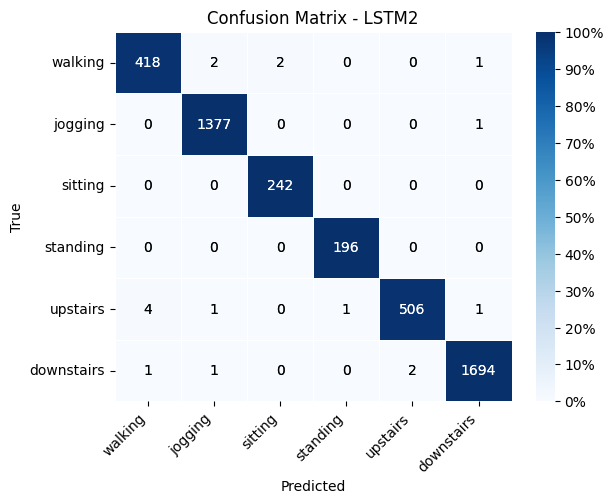

In [ ]:
# Convert predictions and true labels to integer labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix by the true label counts
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with normalized colormap and absolute values
ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', xticklabels=activities, yticklabels=activities, linewidths=.5)

# Annotate with absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
        ax.text(j + 0.5, i + 0.5, format(cm[i, j], 'd'),
                ha='center', va='center', color=text_color)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([i/10.0 for i in range(11)])
colorbar.set_ticklabels([f'{i*10}%' for i in range(11)])

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees
plt.title("Confusion Matrix - LSTM2")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# LSTM3 - Data Augmentation

As previously states we perform data augmentation and train the same architecture of model 2 (LSTM2) on the augmented data.

We will try to obtain **Rotation Invariance** of the signals: the idea is that in the **WISDM** dataset all signals are recorded in with the same protocol; the axes orientation and the location of the smartphones were the same for all subjects. We want to obtain a more robust model, such that it will be able to make predictions even with signals recorded with a different orientation of the smartphone inside the pocket.

Also we will apply jittering to the signals in order to obtain a more balanced dataset.

### LSTM3 - Data Preparation

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, X_train_mean, X_train_std = load_data(data, overlap=0.5, dummy=False, feature_extractor=identity, standardize=True, reshape = False)

Axes means: [0.75847414 7.37186229 0.43398622]
Axes standard deviations: [6.93978176 6.84815271 4.86165218]


In [ ]:
os.makedirs(base_path + 'training_data/LSTM3/', exist_ok=True)

with open(base_path + 'training_data/LSTM3/X_train_mean.pkl', 'wb') as f:
    pickle.dump(X_train_mean, f)

with open(base_path + 'training_data/LSTM3/X_train_std.pkl', 'wb') as f:
    pickle.dump(X_train_std, f)

In [ ]:
print(f"X_train shape: \t{X_train.shape},\tmin value: {X_train.min():.3f}, \tmax value: {X_train.max():.3f}")
print(f"y_train shape: \t{y_train.shape}")

print(f"X_val shape: \t{X_val.shape},\t\tmin value: {X_val.min():.3f}, \tmax value: {X_val.max():.3f}")
print(f"y_val shape: \t{y_val.shape}")

print(f"X_test shape: \t{X_test.shape},\t\tmin value: {X_test.min():.3f}, \tmax value: {X_test.max():.3f}")
print(f"y_test shape: \t{y_test.shape}")

X_train shape: 	(16019, 3, 100),	min value: -17.057, 	max value: 17.427
y_train shape: 	(16019,)
X_val shape: 	(1780, 3, 100),		min value: -8.564, 	max value: 15.977
y_val shape: 	(1780,)
X_test shape: 	(4450, 3, 100),		min value: -9.768, 	max value: 17.427
y_test shape: 	(4450,)


In [ ]:
signal_matrix_shape = X_train.shape
signal_matrix_shape

(16019, 3, 100)

### Data Augmentation

Initially, we define most probable rotations along the x, y, and z axes of the smartphone inside the pocket and generates all possible combinations of these rotations, including random offsets for each signal. Then applies these rotations to the signals, creating an augmented dataset.

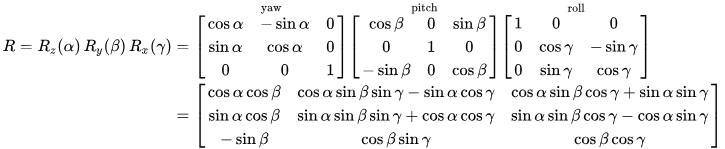

#### Signals Rotation

Define the most probable rotations along each axis and all the possible combinations between them

In [ ]:
from itertools import product

# Set the most probable rotation around each axis
most_probable_rotations = {'x': [0, 180], 'y': [0, 180], 'z': [0, 180]}

# Get all possible combinations
combinations = list(product(*most_probable_rotations.values()))

# Create a list of dictionaries with axis labels and corresponding angles
angles_combinations = [{axis: angle for axis, angle in zip(most_probable_rotations.keys(), combo)} for combo in combinations]

for combination in angles_combinations:
    print(combination)

{'x': 0, 'y': 0, 'z': 0}
{'x': 0, 'y': 0, 'z': 180}
{'x': 0, 'y': 180, 'z': 0}
{'x': 0, 'y': 180, 'z': 180}
{'x': 180, 'y': 0, 'z': 0}
{'x': 180, 'y': 0, 'z': 180}
{'x': 180, 'y': 180, 'z': 0}
{'x': 180, 'y': 180, 'z': 180}


In [ ]:
# Define the maximum offset from the basic rotation for each axis
std_dev_z = 15   # max_offset=30° -> std_dev = 30/2 = 15
std_dev_y = 10   # max_offset=20° -> std_dev = 20/2 = 10
std_dev_x = 5    # max_offset=10° -> std_dev = 10/2 = 5

# Create random offsets for each signal along each axis
offsets_z = np.random.normal(0, std_dev_z, size=(signal_matrix_shape[0], len(angles_combinations)))
offsets_y = np.random.normal(0, std_dev_y, size=(signal_matrix_shape[0], len(angles_combinations)))
offsets_x = np.random.normal(0, std_dev_x, size=(signal_matrix_shape[0], len(angles_combinations)))

# Initialize an empty array to store rotated signals shape:(8,16019,3,100) -> 8 combinations, 16019 signals
rotated_signals = np.empty((len(angles_combinations), *signal_matrix_shape[0:]))
rotated_labels = np.empty((len(angles_combinations), *y_train.shape[0:]), dtype="<U10")

In [ ]:
print(rotated_signals.shape)
print(rotated_labels.shape)

(8, 16019, 3, 100)
(8, 16019)


In [ ]:
offsets_z.shape # each signal (16019) gets rotated with all possible angle combinations (8)

(16019, 8)

In [ ]:
# The external loop iterates through the signals
for j in tqdm(range(signal_matrix_shape[0])):

    #The internal loop iterates through the angles_combinations, 'i' is the index of the current combination
    for i, combination in zip(range(len(angles_combinations)), angles_combinations):

        # euler_angles contains the "most probable rotation angle" around each axis + its offset
        euler_angles = [
            combination['z'] + offsets_z[j, i],
            combination['y'] + offsets_y[j, i],
            combination['x'] + offsets_x[j, i]
        ]

        # Creates a rotation matrix from the given angles (it uses Intrinsic Rotation convention (ZYX))
        rotation = Rotation.from_euler('ZYX', euler_angles, degrees=True).as_matrix()

        # Rotates the current signal
        rotated_signal = np.matmul(rotation, X_train[j])

        # Appends the rotated signal to the list of rotated signals
        rotated_signals[i,j] = rotated_signal
        rotated_labels[i,j] = y_train[j]


100%|██████████| 16019/16019 [00:06<00:00, 2609.67it/s]


In [ ]:
rotated_signals = np.reshape(rotated_signals, (-1, *X_train.shape[1:]))
rotated_signals.shape

(128152, 3, 100)

In [ ]:
rotated_labels = np.reshape(rotated_labels, (rotated_labels.shape[0]*rotated_labels.shape[1]))
rotated_labels.shape

(128152,)

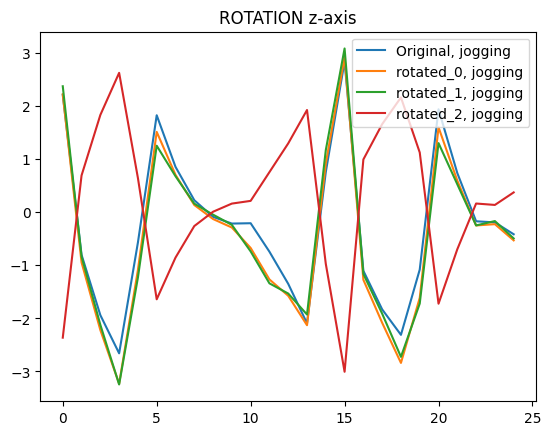

In [ ]:
plt.plot(X_train[600, 2, :25], label=f'Original, {y_train[600]} ')
plt.plot(rotated_signals[600, 2, :25], label=f'rotated_0, {rotated_labels[600]}')
plt.plot(rotated_signals[600+16019, 2, :25], label=f'rotated_1, {rotated_labels[600+16019]}')
plt.plot(rotated_signals[600+16019*2, 2, :25], label=f'rotated_2, {rotated_labels[600+16019*2]}')
plt.title('ROTATION z-axis')
plt.legend()
plt.show()

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{'downstairs': 1524,
 'jogging': 4960,
 'sitting': 869,
 'standing': 706,
 'upstairs': 1845,
 'walking': 6115}

In [ ]:
unique, counts = np.unique(rotated_labels, return_counts=True)
dict(zip(unique, counts))

{'downstairs': 12192,
 'jogging': 39680,
 'sitting': 6952,
 'standing': 5648,
 'upstairs': 14760,
 'walking': 48920}

Adding the original data to the rotated ones

In [ ]:
X_train = np.concatenate((X_train, rotated_signals), axis=0)
y_train = np.concatenate((y_train, rotated_labels), axis=0)

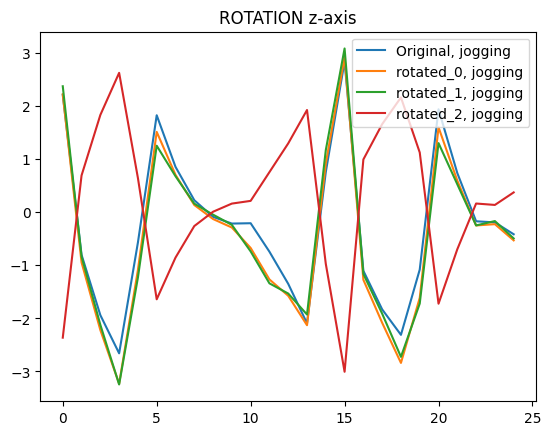

In [ ]:
plt.plot(X_train[600, 2, :25], label=f'Original, {y_train[600]} ')
plt.plot(X_train[600+16019, 2, :25], label=f'rotated_0, {y_train[600+16019]}')
plt.plot(X_train[600+16019*2, 2, :25], label=f'rotated_1, {y_train[600+16019*2]}')
plt.plot(X_train[600+16019*3, 2, :25], label=f'rotated_2, {y_train[600+16019*3]}')
plt.title('ROTATION z-axis')
plt.legend()
plt.show()

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{'downstairs': 13716,
 'jogging': 44640,
 'sitting': 7821,
 'standing': 6354,
 'upstairs': 16605,
 'walking': 55035}

#### Class Balancing with jittering

We use jittering, which adds random noise to the signals, to balance the class distribution. The augmented and original data are then combined, and class labels are updated accordingly. Finally, the augmented dataset is reshaped and transposed, preparing it for model training

In [ ]:
y_train_dummy = np.asarray(pd.get_dummies(y_train), dtype = np.float32)
dict(zip(unique, np.sum(y_train_dummy, axis=0)))

{'downstairs': 13716.0,
 'jogging': 44640.0,
 'sitting': 7821.0,
 'standing': 6354.0,
 'upstairs': 16605.0,
 'walking': 55035.0}

In [ ]:
def jitter_sample(X, sigma = 0.2):
  generated_noise = np.random.normal(loc=0, scale=sigma, size=X.shape)
  return X + generated_noise

In [ ]:
jitter_prova = jitter_sample(X_train[0])

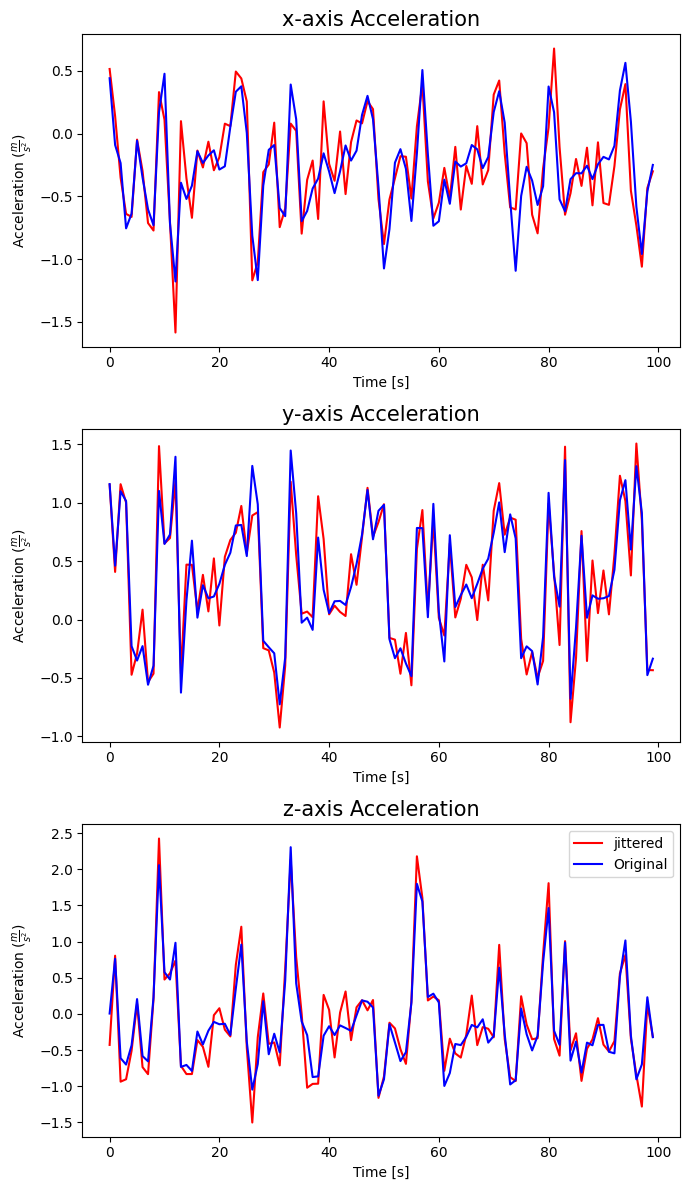

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(7,12))

label_fontsize = 10

ax[0].plot(jitter_prova[0], 'r', label='jittered')
ax[0].plot(X_train[0][0], 'blue', label='Original')
ax[0].set_title("x-axis Acceleration", fontsize=label_fontsize+5)
ax[0].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[0].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

ax[1].plot(jitter_prova[1], 'r', label='jittered')
ax[1].plot(X_train[0][1], 'blue', label='Original')
ax[1].set_title("y-axis Acceleration", fontsize=label_fontsize+5)
ax[1].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[1].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

ax[2].plot(jitter_prova[2], 'r', label='jittered')
ax[2].plot(X_train[0][2], 'blue', label='Original')
ax[2].set_title("z-axis Acceleration", fontsize=label_fontsize+5)
ax[2].set_xlabel('Time [s]', fontsize=label_fontsize)
ax[2].set_ylabel('Acceleration ($\\frac{m}{s^2}$)', fontsize=label_fontsize)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
np.sum(y_train_dummy, axis=0)

array([13716., 44640.,  7821.,  6354., 16605., 55035.], dtype=float32)

In [ ]:
def augmenting_data(X_train, y_train_dummy):
  num_classes = y_train_dummy.shape[1]
  class_counts = np.sum(y_train_dummy, axis=0)
  max_count = np.max(class_counts)
  new_X_train = []
  new_y_train_dummy = []

  for class_label in range(num_classes):
    indices = np.where(y_train_dummy[:, class_label] == 1)[0]
    num_samples = len(indices)
    num_jittered_samples = max_count - num_samples

    if num_jittered_samples > 0:
      cyclic_indices = itertools.cycle(list(indices))
      jittered_indices = list(itertools.islice(cyclic_indices, math.floor(num_jittered_samples)))

      jittered_X = []
      for n in jittered_indices:
        jittered_n = jitter_sample(X_train[n])
        jittered_X.append(jittered_n)

      jittered_y = np.zeros((int(num_jittered_samples), num_classes))
      jittered_y[:, class_label] = 1

      new_X_train.append(jittered_X)
      new_y_train_dummy.append(jittered_y)

  if len(new_X_train) > 0:
    new_X_train = np.vstack(new_X_train)
    new_y_train_dummy = np.vstack(new_y_train_dummy)
    X_train = np.vstack((X_train, new_X_train))
    y_train_dummy = np.vstack((y_train_dummy, new_y_train_dummy))

  return X_train, y_train_dummy

In [ ]:
X_train_aug, y_train_aug_dummy = augmenting_data(X_train, y_train_dummy)

In [ ]:
y_val_dummy = np.asarray(pd.get_dummies(y_val), dtype = np.float32)
y_test_dummy = np.asarray(pd.get_dummies(y_test), dtype = np.float32)

In [ ]:
print(f"X_train shape: \t{X_train_aug.shape},\tmin value: {X_train_aug.min():.3f}, \tmax value: {X_train_aug.max():.3f}")
print(f"y_train shape: \t{y_train_aug_dummy.shape}")

print(f"X_val shape: \t{X_val.shape},\t\tmin value: {X_val.min():.3f}, \tmax value: {X_val.max():.3f}")
print(f"y_val shape: \t{y_val_dummy.shape}")

print(f"X_test shape: \t{X_test.shape},\t\tmin value: {X_test.min():.3f}, \tmax value: {X_test.max():.3f}")
print(f"y_test shape: \t{y_test_dummy.shape}")

X_train shape: 	(330210, 3, 100),	min value: -18.716, 	max value: 21.435
y_train shape: 	(330210, 6)
X_val shape: 	(1780, 3, 100),		min value: -8.564, 	max value: 15.977
y_val shape: 	(1780, 6)
X_test shape: 	(4450, 3, 100),		min value: -9.768, 	max value: 17.427
y_test shape: 	(4450, 6)


In [ ]:
np.sum(y_train_aug_dummy, axis=0)

array([55035., 55035., 55035., 55035., 55035., 55035.])

In [ ]:
labels = np.unique(y_train)
labels

array(['downstairs', 'jogging', 'sitting', 'standing', 'upstairs',
       'walking'], dtype='<U10')

In [ ]:
y_train_aug = np.array([
    ''.join(labels[label == 1])
    for label in y_train_aug_dummy
])

In [ ]:
dict(zip(unique, np.sum(y_train_aug_dummy, axis=0)))
for label, n in zip(unique, np.sum(y_train_aug_dummy, axis=0)):
  print(f'{label}: \t{int(n)}')

downstairs: 	55035
jogging: 	55035
sitting: 	55035
standing: 	55035
upstairs: 	55035
walking: 	55035


In [ ]:
X_train = X_train_aug.transpose(0, 2, 1)
X_val = X_val.transpose(0, 2, 1)
X_test = X_test.transpose(0, 2, 1)

In [ ]:
y_train = y_train_aug_dummy
y_val = y_val_dummy
y_test = y_test_dummy

In [ ]:
print(f"X_train shape: \t{X_train.shape},\tmin value: {X_train.min():.3f}, \tmax value: {X_train.max():.3f}")
print(f"y_train shape: \t{y_train.shape}")

print(f"X_val shape: \t{X_val.shape},\t\tmin value: {X_val.min():.3f}, \tmax value: {X_val.max():.3f}")
print(f"y_val shape: \t{y_val.shape}")

print(f"X_test shape: \t{X_test.shape},\t\tmin value: {X_test.min():.3f}, \tmax value: {X_test.max():.3f}")
print(f"y_test shape: \t{y_test.shape}")

X_train shape: 	(330210, 100, 3),	min value: -18.716, 	max value: 21.435
y_train shape: 	(330210, 6)
X_val shape: 	(1780, 100, 3),		min value: -8.564, 	max value: 15.977
y_val shape: 	(1780, 6)
X_test shape: 	(4450, 100, 3),		min value: -9.768, 	max value: 17.427
y_test shape: 	(4450, 6)


## LSTM3 - Definition

LSTM3 has the same architecture of LSTM2, but is trained on augmented data

In [ ]:
input_shape = (X_train.shape[1:])
num_classes = y_train.shape[1]
print(f"Input shape:\t\t{input_shape}\nNumber of classes:\t{num_classes}")

Input shape:		(100, 3)
Number of classes:	6


In [ ]:
def create_model(input_shape, num_classes):
    input_layer = keras.layers.Input(shape=(100, 3))

    # First LSTM layer with batch normalization
    x = keras.layers.LSTM(128, return_sequences=True)(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)

    # Second LSTM layer with batch normalization
    x = keras.layers.LSTM(128, return_sequences=True)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)

    # Third LSTM layer with batch normalization
    x = keras.layers.LSTM(128, return_sequences=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)

    # Dense layer
    output_layer = keras.layers.Dense(len(activities), activation='softmax')(x)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer, name = 'LSTM3')
    return model

In [ ]:
LSTM3 = create_model(input_shape, num_classes)
LSTM3.summary()

Model: "LSTM3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 128)          67584     
                                                                 
 batch_normalization_3 (Bat  (None, 100, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 100, 128)          131584    
                                                                 
 batch_normalization_4 (Bat  (None, 100, 128)          512       
 chNormalization)                                            

## LSTM3 - Parameters and Callbacks

In [ ]:
# Hyperparameters
lr = 0.001
epochs = 100
batch_size = 256

# Optimizer, Loss and Metrics
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_function = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']

Callbacks

In [ ]:
# Reduce Learning Rate On Plateau
callback_rp = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.5,
                                                patience=5,
                                                min_lr=1e-8,
                                                verbose=1)

# Early Stopping
callback_es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True,
                                            verbose=1)

# Model Checkpoint
LSTM3_checkpoint_filepath = base_path + 'Models/LSTM3_checkpoint.keras'
callback_cp = keras.callbacks.ModelCheckpoint(LSTM3_checkpoint_filepath,
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              verbose=1
                                              )

# Backup and Restore
callback_br = keras.callbacks.BackupAndRestore(backup_dir = base_path + "backup/LSTM3")

# CSV Logger for history saving
history_LSTM3_filepath = base_path + 'backup/history_LSTM3.csv'
callback_CVS = keras.callbacks.CSVLogger(history_LSTM3_filepath, separator=",", append=True)

callbacks = [callback_rp, callback_es, callback_cp, callback_br, callback_CVS]

Compile the model

In [ ]:
LSTM3.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

## LSTM3 - Training

In [ ]:
# Train the model
history_LSTM3 = LSTM3.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(X_val, y_val),
                          callbacks=callbacks)

Epoch 1/100
1290/1290 [==============================] - ETA: 0s - loss: 0.4887 - accuracy: 0.8237
Epoch 1: val_loss improved from inf to 0.13594, saving model to /content/drive/MyDrive/DSaIM_project/1D/Models/LSTM3_checkpoint.keras
1290/1290 [==============================] - 59s 38ms/step - loss: 0.4887 - accuracy: 0.8237 - val_loss: 0.1359 - val_accuracy: 0.9545 - lr: 0.0010
Epoch 2/100
1289/1290 [============================>.] - ETA: 0s - loss: 0.1573 - accuracy: 0.9496
Epoch 2: val_loss improved from 0.13594 to 0.06736, saving model to /content/drive/MyDrive/DSaIM_project/1D/Models/LSTM3_checkpoint.keras
1290/1290 [==============================] - 49s 38ms/step - loss: 0.1573 - accuracy: 0.9496 - val_loss: 0.0674 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 3/100
1289/1290 [============================>.] - ETA: 0s - loss: 0.1084 - accuracy: 0.9665
Epoch 3: val_loss improved from 0.06736 to 0.04200, saving model to /content/drive/MyDrive/DSaIM_project/1D/Models/LSTM3_checkpoint.ker

In [ ]:
# Load the CSV file
history_df = pd.read_csv(history_LSTM3_filepath)

In [ ]:
best_epoch = history_df['val_loss'].idxmin()
best_val_loss = history_df['val_loss'].min()
best_val_accuracy = history_df['val_accuracy'].iloc[best_epoch]

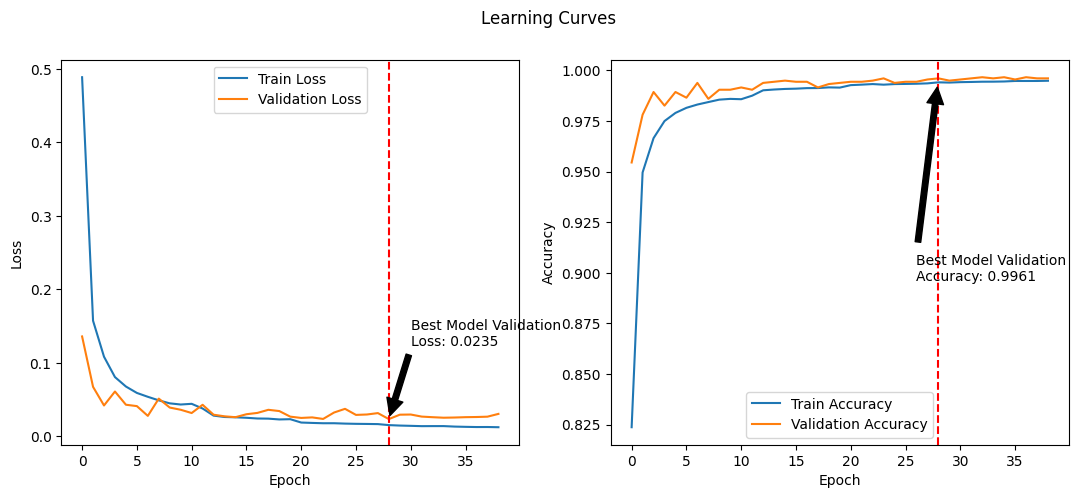

In [ ]:
plt.figure(figsize=(13, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Vertical line at the best epoch
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (epoch {best_epoch})')

# Add text annotation for the best validation loss
plt.annotate(f'Best Model Validation\nLoss: {best_val_loss:.4f}',
             xy=(best_epoch, best_val_loss),
             xytext=(best_epoch + 2, best_val_loss + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (epoch {best_epoch})')

# Add text annotation for the best validation loss
plt.annotate(f'Best Model Validation\nAccuracy: {best_val_accuracy:.4f}',
             xy=(best_epoch, best_val_accuracy),
             xytext=(best_epoch - 2, best_val_accuracy - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.suptitle('Learning Curves')
plt.show()

## LSTM3 - Evaluation

In [ ]:
# Load the model
LSTM3_checkpoint_filepath = base_path + 'Models/LSTM3_checkpoint.keras'
LSTM3 = keras.models.load_model(LSTM3_checkpoint_filepath)

# Verify the loaded model
loss, acc = LSTM3.evaluate(X_test, y_test)
print(f"LSTM3 accuracy on test data: {acc * 100:.2f}%")

140/140 [==============================] - 17s 105ms/step - loss: 0.0408 - accuracy: 0.9944
LSTM3 accuracy on test data: 99.44%


In [ ]:
# Predict the probabilities for the test data
y_pred_prob = LSTM3.predict(X_test)

140/140 [==============================] - 16s 103ms/step


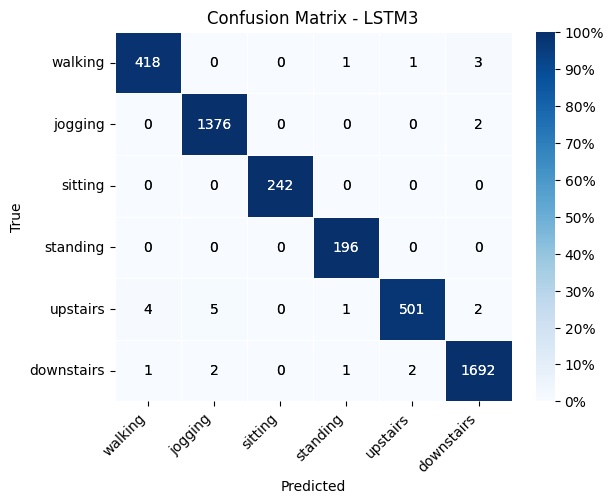

In [ ]:
# Convert predictions and true labels to integer labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix by the true label counts
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with normalized colormap and absolute values
ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', xticklabels=activities, yticklabels=activities, linewidths=.5)

# Annotate with absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
        ax.text(j + 0.5, i + 0.5, format(cm[i, j], 'd'),
                ha='center', va='center', color=text_color)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([i/10.0 for i in range(11)])
colorbar.set_ticklabels([f'{i*10}%' for i in range(11)])

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees
plt.title("Confusion Matrix - LSTM3")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()